In [116]:
import os
import librosa
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model

### Step 1: Split the dataset into training and test sets

In [80]:
pathHappy = "data_folder/happy/"
pathFear = "data_folder/fear/"
pathAngry = "data_folder/angry/"
pathSad = "data_folder/sad/"

filesHappy = librosa.util.find_files(pathHappy)
filesFear = librosa.util.find_files(pathFear)
filesAngry = librosa.util.find_files(pathAngry)
filesSad = librosa.util.find_files(pathSad)

In [81]:
filesHappy = np.asarray(filesHappy)
filesFear = np.asarray(filesFear)
filesAngry = np.asarray(filesAngry)
filesSad = np.asarray(filesSad)

In [82]:
targets_h = np.full(100, 1) # array of 1s for happy target

train_h, test_h, target_h,  t_h= train_test_split(filesHappy, targets_h, test_size = 0.3, shuffle=True, random_state=42)

targets_f = np.full(100, 2) # array of 2s for fear target

train_f, test_f, target_f, t_f = train_test_split(filesFear, targets_f, test_size = 0.3, shuffle=True, random_state=42)

targets_a = np.full(100, 3) # array of 3s for angry target

train_a, test_a, target_a, t_a = train_test_split(filesAngry, targets_a, test_size = 0.3, shuffle=True, random_state=42)

targets_s = np.full(100, 4) # array of 4s for sad target

train_s, test_s, target_s, t_s = train_test_split(filesSad, targets_s, test_size = 0.3, shuffle=True, random_state=42)

np.info(train_s)

class:  ndarray
shape:  (70,)
strides:  (372,)
itemsize:  372
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x1cdf9030400
byteorder:  little
byteswap:  False
type: <U93


In [83]:
train = np.append(train_h, train_f)
train = np.append(train, train_a)
train = np.append(train, train_s)

np.info(train)

class:  ndarray
shape:  (280,)
strides:  (388,)
itemsize:  388
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x1cdf02fac10
byteorder:  little
byteswap:  False
type: <U97


In [84]:
target = np.append(target_h, target_f)
target = np.append(target, target_a)
target = np.append(target, target_s)

np.info(target)

class:  ndarray
shape:  (280,)
strides:  (4,)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x1cdf224bd70
byteorder:  little
byteswap:  False
type: int32


In [85]:
test = np.append(test_h, test_f)
test = np.append(test, test_a)
test = np.append(test, test_s)

np.info(test)

class:  ndarray
shape:  (120,)
strides:  (388,)
itemsize:  388
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x1cde7e3d190
byteorder:  little
byteswap:  False
type: <U97


In [86]:
t = np.append(t_h, t_f)
t = np.append(t, t_a)
t = np.append(t, t_s)

np.info(t)

class:  ndarray
shape:  (120,)
strides:  (4,)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x1cde295e880
byteorder:  little
byteswap:  False
type: int32


### Step 2. Exploratory Data Analysis

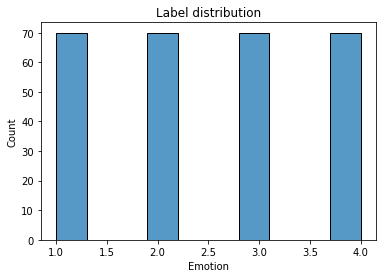

In [93]:
sns.histplot(data=target, palette='bright')
plt.title("Label distribution")
plt.xlabel("Emotion")
plt.show()

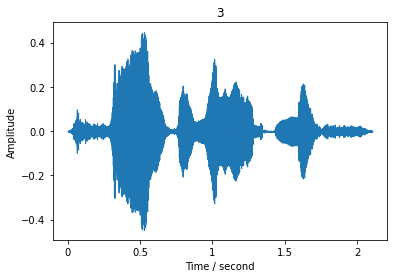

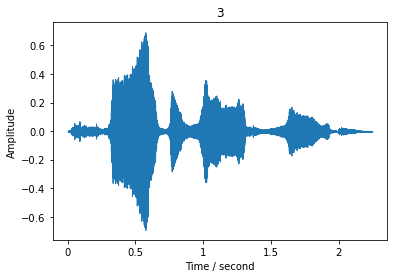

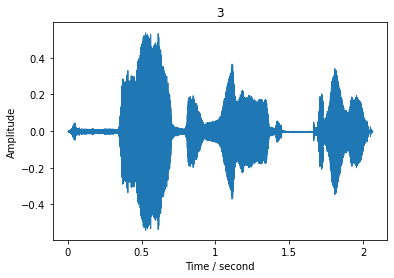

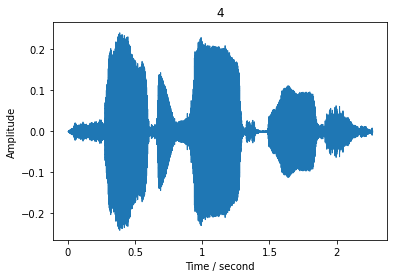

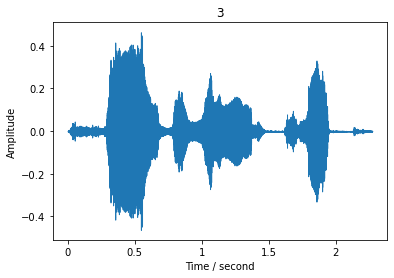

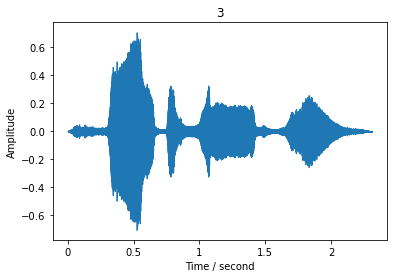

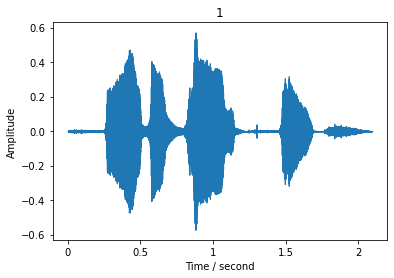

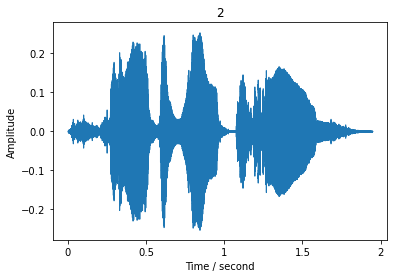

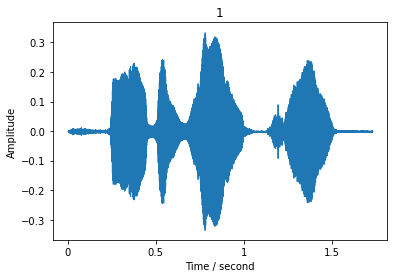

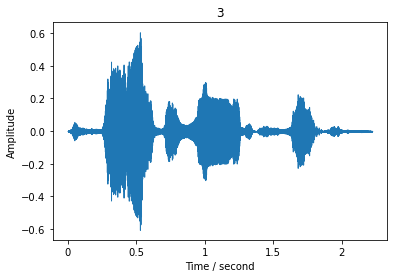

In [88]:
# sample of 10 files in time domain
rand_nums = random.sample(range(280), 10)
train_rand = np.array([train[i] for i in rand_nums])
t_rand = np.array([target[i] for i in rand_nums])

for i in range(len(train_rand)): 
    signal, sample_rate = librosa.load(train_rand[i], sr = 16000,mono = True)   
    librosa.display.waveshow(y=signal, sr=sample_rate)
    plt.xlabel('Time / second')
    plt.ylabel('Amplitude')
    plt.title(t_rand[i])
    plt.show()

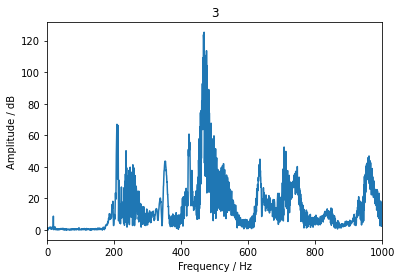

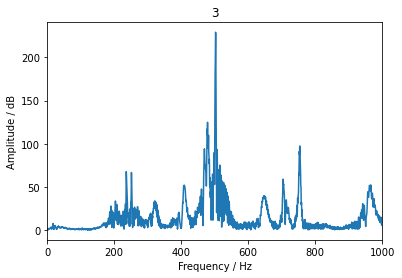

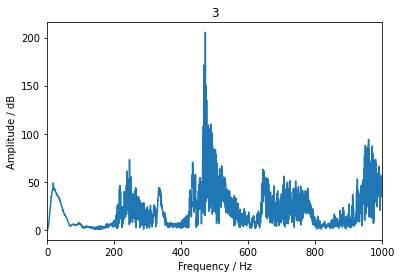

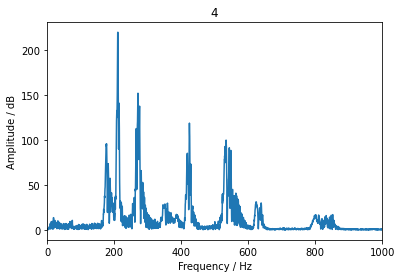

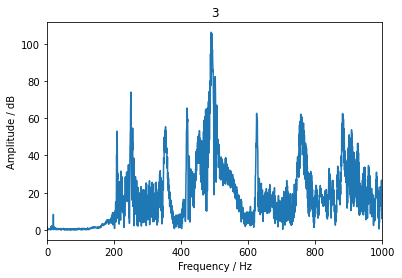

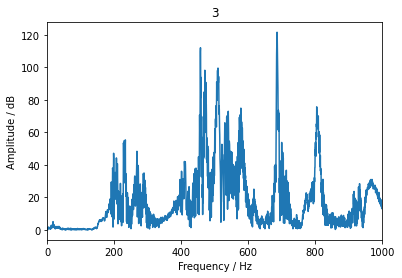

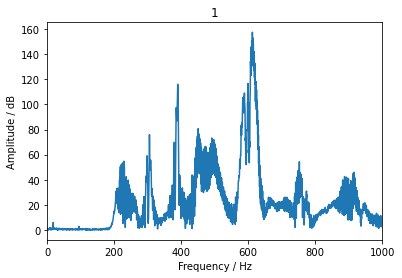

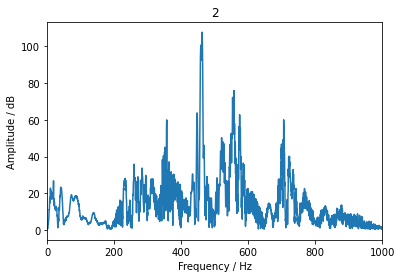

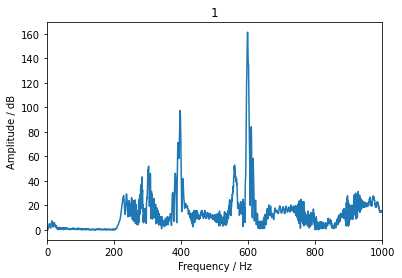

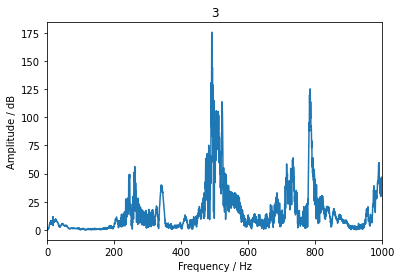

In [89]:
# sample of 10 files in the frequency domain (some code copied from Coding Materials)
for i in range(len(train_rand)):  
    signal, sample_rate = librosa.load(train_rand[i], sr = 16000,mono = True)   
    k = np.arange(len(signal))
    T = len(signal)/sample_rate
    freq = k/T

    DATA_0 = np.fft.fft(signal)
    abs_DATA_0 = abs(DATA_0)
    plt.figure(2)
    plt.plot(freq, abs_DATA_0)
    plt.title(t_rand[i])
    plt.xlabel("Frequency / Hz")
    plt.ylabel("Amplitude / dB")
    plt.xlim([0, 1000])
    plt.show()

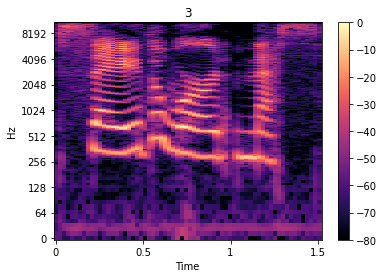

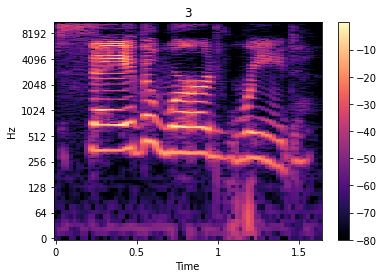

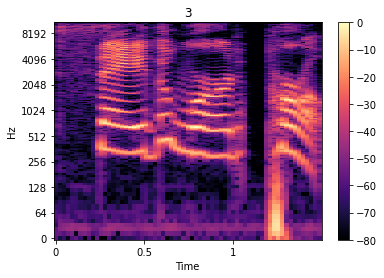

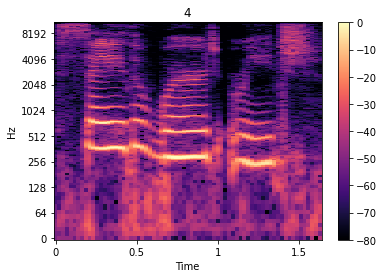

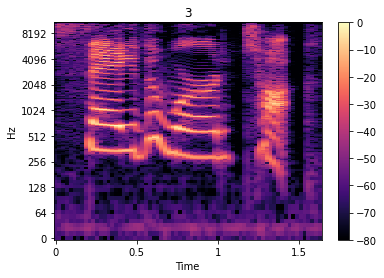

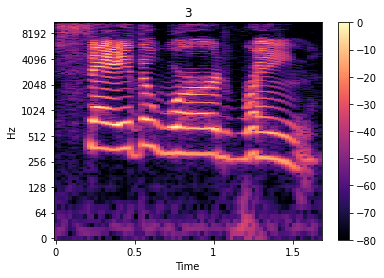

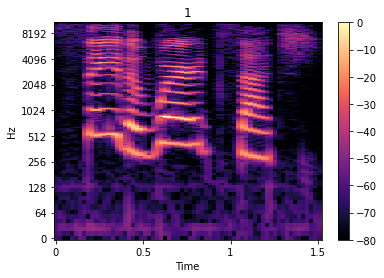

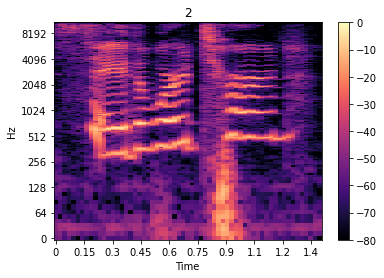

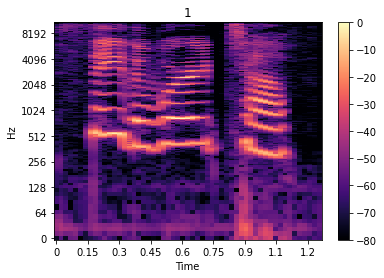

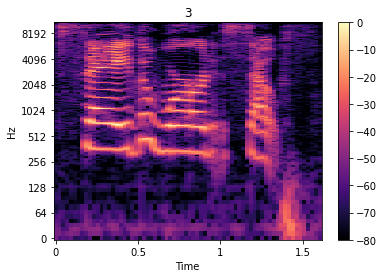

In [90]:
# sample of 10 files in the time-frequency domain (some code copied from Coding Materials)
for i in range(len(train_rand)): 
    signal, sample_rate = librosa.load(train_rand[i], sr = 16000,mono = True)  
    D = librosa.stft(signal)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(3)
    librosa.display.specshow(S_db, x_axis='time', y_axis='log')
    plt.title(t_rand[i])
    plt.colorbar()
    plt.show()

### Step 3 + 4. Acoustic Feature Extraction and Feature Post-Processing

In [125]:
train_final = []
# going to use mel, chroma, mfcc, and zero-crossing rate
for X in train:
    result = np.array([])
    signal, sample_rate = librosa.load(X, sr = 16000,mono = True)
    
    mel = np.mean(librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=12).T, axis=0)
    result = np.hstack((result, mel))
    
    stft = np.abs(librosa.stft(signal))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result = np.hstack((result, chroma))
    
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))
    
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=signal).T, axis=0)
    result = np.hstack((result, zcr))
    
    train_final.append(result)
    
train_final = np.array(train_final)

In [126]:
#Same for test set
test_final = []
# going to use mel, chroma, mfcc, and zero-crossing rate
for X in test:
    result = np.array([])
    signal, sample_rate = librosa.load(X, sr = 16000,mono = True)
    
    mel = np.mean(librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=12).T, axis=0)
    result = np.hstack((result, mel))
    
    stft = np.abs(librosa.stft(signal))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result = np.hstack((result, chroma))
    
    mfcc = np.mean(librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))
    
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=signal).T, axis=0)
    result = np.hstack((result, zcr))
    
    test_final.append(result)
    
test_final = np.array(test_final)
test_final[:5]

array([[ 2.78944135e+00,  1.08825836e+01,  7.50644064e+00,
         4.32202637e-01,  4.96461809e-01,  7.82982945e-01,
         1.01789522e+00,  7.35965133e-01,  2.70323604e-01,
         1.84393838e-01,  2.24445969e-01,  3.10021476e-03,
         4.48365122e-01,  3.80865276e-01,  4.84215349e-01,
         5.33626258e-01,  3.89551610e-01,  3.56823772e-01,
         3.89460534e-01,  3.82027835e-01,  4.61981893e-01,
         5.09998560e-01,  5.12017787e-01,  4.61066157e-01,
        -3.11361664e+02,  2.50672646e+01, -4.85495710e+00,
         1.70774899e+01, -1.87905521e+01,  7.78478909e+00,
        -2.57263489e+01, -1.17969990e+00, -1.16400042e+01,
        -3.37210584e+00,  7.46299458e+00, -9.65892220e+00,
         7.87922525e+00, -5.83500338e+00,  3.52104807e+00,
         6.09738922e+00, -5.50199413e+00,  1.12446797e+00,
        -7.41369438e+00,  2.75130749e-01,  6.27318192e+00,
         1.16764174e+01,  4.25448942e+00,  4.02352428e+00,
         8.67032051e-01,  8.37811565e+00,  1.01635923e+0

### Step 5: Audio emotion Recognition Model

In [129]:
nbc = GaussianNB()
rfc = RandomForestClassifier()
svm = SVC(probability=True)
knn = KNeighborsClassifier(n_neighbors = 7)

model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}

mlp = MLPClassifier(**model_params)

In [130]:
nbc.fit(train_final, target)
rfc.fit(train_final, target)
svm.fit(train_final, target)
knn.fit(train_final, target)
mlp.fit(train_final, target)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [131]:
y_nbc_predicted = nbc.predict(test_final)
y_nbc_pred_proba = nbc.predict_proba(test_final)

y_rfc_predicted = rfc.predict(test_final)
y_rfc_pred_proba = rfc.predict_proba(test_final)

y_svc_predicted = svm.predict(test_final)
y_svc_pred_proba = svm.predict_proba(test_final)

y_knn_predicted = knn.predict(test_final)
y_knn_pred_proba = knn.predict_proba(test_final)

y_mlp_predicted = mlp.predict(test_final)
y_mlp_pred_proba = mlp.predict_proba(test_final)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        30

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        30

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

              precision    recall  f1-score   support

           1       0.94      0.97      0.95        30
           2       1.

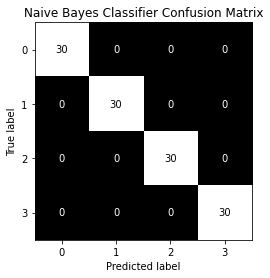

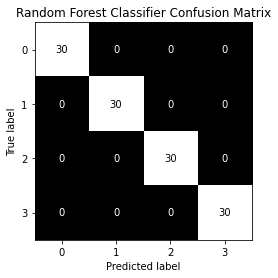

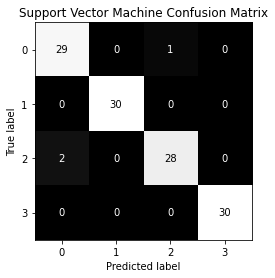

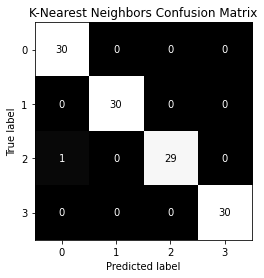

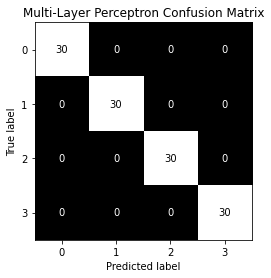

In [135]:
#Copied from class coding materials with a few adjustments

print(classification_report(t, y_nbc_predicted))
print(classification_report(t, y_rfc_predicted))
print(classification_report(t, y_svc_predicted))
print(classification_report(t, y_knn_predicted))
print(classification_report(t, y_mlp_predicted))

models = ['Naive Bayes Classifier', 'Random Forest Classifier', 'Support Vector Machine', 'K-Nearest Neighbors',
         'Multi-Layer Perceptron']
predictions = [y_nbc_predicted, y_rfc_predicted, y_svc_predicted, y_knn_predicted, y_mlp_predicted]
pred_probabilities = [y_nbc_pred_proba, y_rfc_pred_proba, y_svc_pred_proba, y_knn_pred_proba, y_mlp_predicted]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(t.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.show()